<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [2]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

In [3]:
def clean_descriptions(desc):
    soup = BeautifulSoup(desc, 'html.parser')
    return soup.get_text()

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [4]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
import pandas as pd
df = pd.read_csv('./data/job_listings.csv', index_col=0)

In [5]:
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [18]:
example = df['description'][0]

In [16]:
example

'b"<div><div>Job Requirements:</div><ul><li><p>\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\\n</li><li><p>Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><d

In [19]:
example1 = clean_descriptions(example)

In [54]:
huh = nlp(example1)

In [55]:
type(huh)

spacy.tokens.doc.Doc

In [5]:
df['clean_descriptions'] = df['description'].apply(clean_descriptions)

In [26]:
df['clean_descriptions'] = df['clean_descriptions'].apply(lambda x: x[2:-1].replace('\\n', ' '))

In [30]:
from spacy.tokenizer import Tokenizer

tokenizer = Tokenizer(nlp.vocab)

tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['clean_descriptions'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [31]:
df

,title,clean_descriptions,tokenized_descriptions,word_counts,tokens
0,Data scientist,Job Requirements: Conceptual understanding in ...,"(b""Job, Requirements:\nConceptual, understandi...",144,"[job, requirements:, conceptual, understanding..."
1,Data Scientist I,"Job Description As a Data Scientist 1, you wi...","(b'Job, Description\n\nAs, a, Data, Scientist,...",595,"[job, description, , data, scientist, 1,, hel..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"(b'As, a, Data, Scientist, you, will, be, work...",134,"[data, scientist, working, consulting, busines..."
3,Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener...","(b'$4,969, -, $, 6,756, a, monthContractUnder,...",282,"[$4,969, $6,756, monthcontractunder, general, ..."
4,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...,"(b'Location, :, USA, \xe2\x80\x93, multiple, l...",28,"[location:, usa, \xe2\x80\x93, multiple, locat..."
...,...,...,...,...,...
421,Senior Data Science Engineer,About Us: Want to be part of a fantastic and f...,"(b""About, Us:\nWant, to, be, part, of, a, fant...",743,"[us:, want, fantastic, fun, startup, that\xe2\..."
422,2019 PhD Data Scientist Internship - Forecasti...,"InternshipAt Uber, we ignite opportunity by se...","(b'InternshipAt, Uber, ,, we, ignite, opportun...",375,"[internshipat, uber,, ignite, opportunity, set..."
423,Data Scientist - Insurance,"$200,000 - $350,000 a yearA million people a y...","(b'$200,000, -, $, 350,000, a, yearA, million,...",462,"[$200,000, $350,000, yeara, million, people, y..."
424,Senior Data Scientist,SENIOR DATA SCIENTIST JOB DESCRIPTION ABOUT U...,"(b""SENIOR, DATA, SCIENTIST\nJOB, DESCRIPTION\n...",588,"[senior, data, scientist, job, description, ,..."


In [6]:
df.drop('description', inplace=True, axis=1)

In [7]:
df['title'].value_counts()[:10]

Data Scientist              150
Senior Data Scientist        14
Junior Data Scientist        10
Associate Data Scientist      8
Data Scientist Intern         7
Sr. Data Scientist            6
Principal Data Scientist      6
DATA SCIENTIST                5
Data Scientist II             4
Jr. Data Scientist            4
Name: title, dtype: int64

## 2) Use Spacy to tokenize the listings 

In [8]:
##### Your Code Here #####
nlp = spacy.load("en_core_web_lg")

In [9]:
df['tokenized_descriptions'] = df['clean_descriptions'].apply(lambda x: nlp(x))

In [10]:
type(df['tokenized_descriptions'][0])

spacy.tokens.doc.Doc

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [11]:
##### Your Code Here #####
df['word_counts'] = df['tokenized_descriptions'].apply(lambda x: len(x))

In [32]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [52]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(df['clean_descriptions'])
# transform text
dtm = vect.transform(df['clean_descriptions'])

In [53]:
print(vect.get_feature_names())

['00', '000', '02115', '03', '0305', '0356', '04', '062', '06366', '08', '10', '100', '1000', '1001', '1008', '100k', '100x', '1026036', '105', '1079302', '1082692', '10b', '10ms', '10x', '11', '110k', '112', '114157802', '12', '120', '125', '126', '130', '1315', '1324b', '138', '14', '140', '15', '150', '15000', '159m', '16', '1605', '165', '169334br', '17', '170', '17b', '18', '180', '180008jq', '18b', '19', '190', '190007ji', '19000bn4', '19000c1k', '19004162', '1901744', '1904', '1904labs', '1905', '19050', '1938', '1944', '1967', '1971', '1975', '1979', '1988', '199', '1994', '1999', '1b', '1st', '1strategy', '1tb', '20', '200', '2000', '200020183', '200041695', '2004', '2008', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2050', '21', '210', '2145', '2272', '24', '24m', '25', '250', '25256', '26', '260', '27', '28', '2nd', '2x', '30', '300', '30328', '30bn', '30k', '31', '317', '320', '3201', '33', '33051', '338', '35', '350', '3535', '35million

In [54]:
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [55]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [56]:
dtm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Columns: 8756 entries, 00 to zurich
dtypes: int64(8756)
memory usage: 28.5 MB


In [57]:
dtm_other = dtm

In [60]:
dtm

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df

,title,clean_descriptions,tokenized_descriptions,word_counts,tokens
0,Data scientist,Job Requirements: Conceptual understanding in ...,"(b""Job, Requirements:\nConceptual, understandi...",144,"[job, requirements:, conceptual, understanding..."
1,Data Scientist I,"Job Description As a Data Scientist 1, you wi...","(b'Job, Description\n\nAs, a, Data, Scientist,...",595,"[job, description, , data, scientist, 1,, hel..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"(b'As, a, Data, Scientist, you, will, be, work...",134,"[data, scientist, working, consulting, busines..."
3,Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener...","(b'$4,969, -, $, 6,756, a, monthContractUnder,...",282,"[$4,969, $6,756, monthcontractunder, general, ..."
4,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...,"(b'Location, :, USA, \xe2\x80\x93, multiple, l...",28,"[location:, usa, \xe2\x80\x93, multiple, locat..."
...,...,...,...,...,...
421,Senior Data Science Engineer,About Us: Want to be part of a fantastic and f...,"(b""About, Us:\nWant, to, be, part, of, a, fant...",743,"[us:, want, fantastic, fun, startup, that\xe2\..."
422,2019 PhD Data Scientist Internship - Forecasti...,"InternshipAt Uber, we ignite opportunity by se...","(b'InternshipAt, Uber, ,, we, ignite, opportun...",375,"[internshipat, uber,, ignite, opportunity, set..."
423,Data Scientist - Insurance,"$200,000 - $350,000 a yearA million people a y...","(b'$200,000, -, $, 350,000, a, yearA, million,...",462,"[$200,000, $350,000, yeara, million, people, y..."
424,Senior Data Scientist,SENIOR DATA SCIENTIST JOB DESCRIPTION ABOUT U...,"(b""SENIOR, DATA, SCIENTIST\nJOB, DESCRIPTION\n...",588,"[senior, data, scientist, job, description, ,..."


In [45]:
df['word_counts'].value_counts()[:20]

550    7
579    5
615    4
496    4
232    4
323    4
736    4
536    4
540    4
340    3
603    3
442    3
439    3
549    3
554    3
593    3
429    3
557    3
230    3
566    3
Name: word_counts, dtype: int64

## 4) Visualize the most common word counts

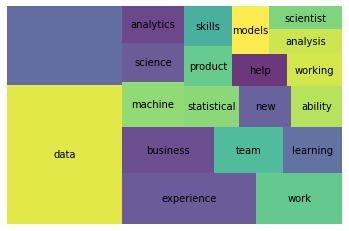

In [35]:
import squarify
wc = count(df['tokens'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()


In [61]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['tokens'].apply(lambda x: word_counts.update(x))


# Print out the 10 most common words
word_counts.most_common(10)

[('data', 3914),
 (' ', 2225),
 ('experience', 1668),
 ('work', 1063),
 ('business', 1052),
 ('team', 787),
 ('learning', 676),
 ('machine', 674),
 ('science', 600),
 ('analytics', 555)]

In [62]:
##### Your Code Here #####
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [64]:
wc = count(df['tokens'])

In [65]:
type(wc['word'][0])

str

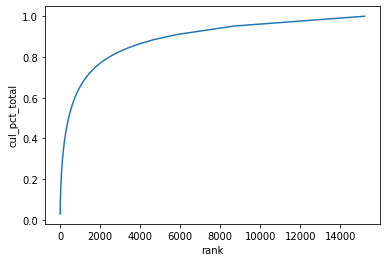

In [66]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [67]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [81]:
tokens_sep = df['tokens']
tokens_lower = tokens_sep.str.join(' ')

In [83]:
tfidf = TfidfVectorizer()

dtm = tfidf.fit_transform(tokens_lower)

dtm_df = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm_df.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.106253,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
##### Your Code Here #####
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(dtm_df) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm_df_fr = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm_df_fr.head()

,5,accelerate,accept,achieve,acquire,act,adapt,add,address,advance,...,verify,view,visit,visualize,want,welcome,win,work,wrangle,write
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [85]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm_df_fr)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [87]:
nn.kneighbors([dtm_df_fr.iloc[0].values])

(array([[0., 0., 0., 0., 0.]]), array([[ 129, 1085,  545,   59,  270]]))

In [89]:
# Query Using kneighbors 
nn.kneighbors([dtm_df_fr.iloc[1095]])

(array([[0., 0., 0., 1., 1.]]), array([[1096, 1097, 1095, 1327, 1329]]))

In [72]:
data_science = [ """
           You are responsible for the collection, cleaning and munging of data to meet the company's purpose. 
           Duties vary according to the industry and may include experimental frameworks for product development 
           and machine learning with the aim to lay a strong data foundation for robust analytics to be performed
"""]

In [90]:
new = tfidf.transform(data_science)
nn.kneighbors(new.todense())

(array([[1., 1., 1., 1., 1.]]), array([[4986, 4989, 4988, 4984, 4987]]))

In [91]:
df['title'][4986]

KeyError: 4986

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 